In [1]:
%load_ext lab_black

# This notebook performs the training by using the NO$_2$ average of the whole MCM, then with that trained model each single pixel is estimated.

In [2]:
# Please import here all the necessary libraries
import pandas as pd
import kaleido

# import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# plt.rcParams["figure.figsize"] = (20,7)
from math import sqrt
from tqdm import tqdm
import plotly.graph_objects as go
import os
import datacube
from scipy.stats import loguniform, uniform
from matplotlib.pyplot import figure
import geopandas as gpd
import openpyxl
import math
from itertools import combinations
import ipywidgets as widgets
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns

# import plotly.express as px
import xarray as xr
from shapely.geometry import box
import glob
import rioxarray as rio
import rasterio

# ML
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, SplineTransformer

# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# from tensorflow import keras

# from keras_tuner.tuners import BayesianOptimization
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor,
)
from sklearn.svm import SVR
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    RationalQuadratic,
    CompoundKernel,
    WhiteKernel,
)
from sklearn.neural_network import MLPRegressor

# Feature Selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV

import tensorflow as tf

# from tensorflow.keras import datasets, layers, models

# Hide Warnings
import warnings

warnings.filterwarnings("ignore")

# Functions

In [3]:
def process_chunk(chunk, clip_poly):
    clipped_chunk = gpd.clip(chunk, clip_poly)
    clipped_chunk = clipped_chunk.to_crs(epsg=3857)
    return clipped_chunk

# Get Data Using ODC

In [4]:
dc = datacube.Datacube(
    app="my_app", config="/Users/rodrigo/Documents/2_PoliMi/odc/datacube.conf"
)
list_of_products = dc.list_products()
list_of_products

name  \
name                                           
Sentinel5P_NO2_CDMX      Sentinel5P_NO2_CDMX   
Sentinel5P_NO2_Milano  Sentinel5P_NO2_Milano   

                                                             description  \
name                                                                       
Sentinel5P_NO2_CDMX    Sentinel-5P NO2 for the metropolitan area of M...   
Sentinel5P_NO2_Milano  Sentinel-5P NO2 for the administrative area of...   

                      license default_crs default_resolution  
name                                                          
Sentinel5P_NO2_CDMX      None        None               None  
Sentinel5P_NO2_Milano    None        None               None

### Mexico City Metropolitan Area

<Axes: >

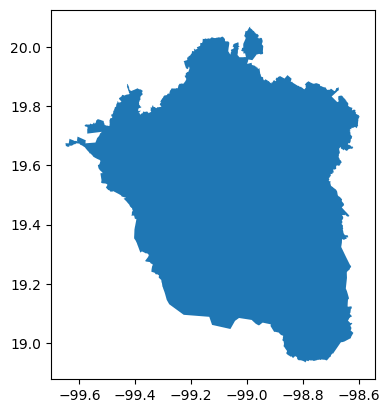

In [5]:
cdmx = gpd.read_file(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/shp/CDMX/cdmx_metrop.shp"
)
cdmx = cdmx.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
cdmx.plot()

In [6]:
cdmx.bounds

minx      miny       maxx       maxy
0 -99.64989  18.93534 -98.596867  20.068262

### Sentinel 5P NO$_2$

In [7]:
product_S5P = "Sentinel5P_NO2_CDMX"
ds_S5P = dc.load(product=product_S5P)
ds_S5P = ds_S5P.where(ds_S5P["tropospheric_NO2_column_number_density"] != -9999)
ds_S5P

<xarray.Dataset>
Dimensions:                                 (time: 1125, latitude: 45,
                                             longitude: 23)
Coordinates:
  * time                                    (time) datetime64[ns] 2019-01-01T...
  * latitude                                (latitude) float64 20.11 ... 18.7
  * longitude                               (longitude) float64 -99.81 ... -9...
    spatial_ref                             int32 4326
Data variables:
    tropospheric_NO2_column_number_density  (time, latitude, longitude) float64 ...
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

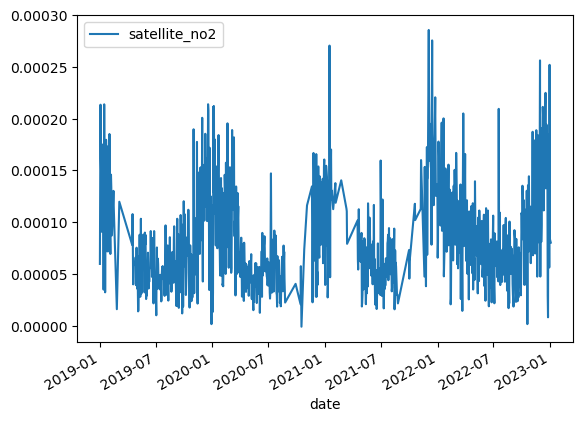

In [8]:
S5P_gdf = ds_S5P.to_dataframe()
del ds_S5P
S5P_gdf = S5P_gdf.dropna()
S5P_gdf = S5P_gdf[["tropospheric_NO2_column_number_density"]]
S5P_gdf.reset_index(drop=False, inplace=True)
S5P_gdf = gpd.GeoDataFrame(
    S5P_gdf, geometry=gpd.points_from_xy(S5P_gdf["longitude"], S5P_gdf["latitude"])
)
S5P_gdf = gpd.clip(S5P_gdf, cdmx.geometry)
S5P_gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
S5P_gdf["date"] = pd.to_datetime(S5P_gdf["time"], format="%Y-%m-%d %H:%M:%S")
S5P_gdf["date"] = S5P_gdf["date"].dt.strftime("%Y-%m-%d")
S5P_gdf["date"] = pd.to_datetime(S5P_gdf["date"], format="%Y-%m-%d")
S5P_gdf.sort_index(inplace=True)
S5P_gdf = S5P_gdf[["date", "tropospheric_NO2_column_number_density", "geometry"]]
S5P_gdf = S5P_gdf.rename(
    columns={"tropospheric_NO2_column_number_density": "satellite_no2"}
)
S5P_gdf.to_csv("/Volumes/Rodrigo_2TB/CDMX/Dataframes/df-s5p-cdmx.csv")
# del S5P_gdf

S5P_gdf["date"] = pd.to_datetime(S5P_gdf["date"], format="%Y-%m-%d")
S5P_gdf_plot = S5P_gdf[["date", "satellite_no2"]].groupby("date").mean()
# S5P_gdf_plot = S5P_gdf_plot[
#    (S5P_gdf_plot.index < "2023-01-01") & (S5P_gdf_plot.index > "2022-01-01")
# ]
# S5P_gdf_plot.reset_index(drop=False, inplace=True)
S5P_gdf_plot.plot()
del S5P_gdf_plot

# For plotting S5P Grid

S5P_gdf_complete = ds_S5P.to_dataframe()
S5P_gdf_complete = S5P_gdf_complete.dropna()
S5P_gdf_gp = S5P_gdf_complete.reset_index(drop=False)
S5P_gdf_gp = gpd.GeoDataFrame(
    S5P_gdf_gp,
    geometry=gpd.points_from_xy(S5P_gdf_gp["longitude"], S5P_gdf_gp["latitude"]),
)
S5P_gdf_gp.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
S5P_gdf_gp = gpd.clip(S5P_gdf_gp, cdmx.geometry)
S5P_gdf_gp = S5P_gdf_gp[
    ["latitude", "longitude", "tropospheric_NO2_column_number_density"]
]
S5P_gdf_gp = S5P_gdf_gp.groupby(["latitude", "longitude"]).mean()
S5P_gdf_gp.reset_index(drop=False, inplace=True)
S5P_gdf_gp = S5P_gdf_gp[["latitude", "longitude"]]
S5P_gdf_gp

# CDMX Ground Sensors NO$_2$ 

In [9]:
cdmx_no2 = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/CDMX/CDMX_no2_Sensors.csv",
    index_col=0,
)
cdmx_no2 = cdmx_no2.rename(columns={"no2": "ground_no2", "datetime": "date"})
cdmx_no2.reset_index(drop=True, inplace=True)
cdmx_no2["date"] = pd.to_datetime(cdmx_no2["date"], format="%Y-%m-%d %H:%M:%S")
cdmx_no2.set_index("date", inplace=True, drop=True)
cdmx_no2 = gpd.GeoDataFrame(
    cdmx_no2, geometry=gpd.points_from_xy(cdmx_no2["lng"], cdmx_no2["lat"])
)
cdmx_no2.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
cdmx_no2.dropna(axis=0, inplace=True)
cdmx_no2.to_csv("/Volumes/Rodrigo_2TB/CDMX/Dataframes/df-no2_stations-cdmx.csv")
# del cdmx_no2

In [10]:
np.sort(cdmx_no2["station"].unique())

array(['ACO', 'AJM', 'AJU', 'ATI', 'BJU', 'CAM', 'CCA', 'CHO', 'CUA',
       'CUT', 'FAC', 'FAR', 'GAM', 'HGM', 'IZT', 'LLA', 'MER', 'MGH',
       'MON', 'MPA', 'NEZ', 'PED', 'SAC', 'SAG', 'SFE', 'TAH', 'TLA',
       'TLI', 'UAX', 'UIZ', 'VIF', 'XAL'], dtype=object)

In [11]:
# Convert all float64 columns to float16
float64_cols = cdmx_no2.select_dtypes(include=["float64"]).columns
cdmx_no2[float64_cols] = cdmx_no2[float64_cols].astype("float16")
cdmx_no2.dtypes

station         object
lat            float16
lng            float16
ground_no2     float16
geometry      geometry
dtype: object

In [12]:
cdmx_no2

station        lat      lng  ground_no2  \
date                                                          
2019-01-01 03:00:00     ACO  19.625000 -98.8750        22.0   
2019-01-01 04:00:00     ACO  19.625000 -98.8750        19.0   
2019-01-01 05:00:00     ACO  19.625000 -98.8750        18.0   
2019-01-01 06:00:00     ACO  19.625000 -98.8750        15.0   
2019-01-01 07:00:00     ACO  19.625000 -98.8750        13.0   
...                     ...        ...      ...         ...   
2024-03-10 21:00:00     XAL  19.515625 -99.0625        39.0   
2024-03-10 22:00:00     XAL  19.515625 -99.0625        44.0   
2024-03-11 03:00:00     XAL  19.515625 -99.0625        40.0   
2024-03-11 04:00:00     XAL  19.515625 -99.0625        40.0   
2024-03-11 05:00:00     XAL  19.515625 -99.0625        44.0   

                                       geometry  
date                                             
2019-01-01 03:00:00  POINT (-98.89900 19.63100)  
2019-01-01 04:00:00  POINT (-98.89900 19.63100)  
2019-01-01 05:00:00  POINT (-98.89900 19.63100)  
2019-01-01 06:00:00  POINT (-98.89900 19.63100)  
2019-01-01 07:00:00  POINT (-98.89900 19.63100)  
...                                         ...  
2024-03-10 21:00:00  POINT (-99.08400 19.52000)  
2024-03-10 22:00:00  POINT (-99.08400 19.52000)  
2024-03-11 03:00:00  POINT (-99.08400 19.52000)  
2024-03-11 04:00:00  POINT (-99.08400 19.52000)  
2024-03-11 05:00:00  POINT (-99.08400 19.52000)  

[925154 rows x 5 columns]

# ERA5 Meteo Data

In [13]:
# Specify the directory containing the .nc files
directory_path = "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/ERA5/CDMX/individual_files"
# output_path = (
#   "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/ERA5/CDMX"
# )
# Construct the glob pattern for all .nc files in the directory
nc_files_pattern = os.path.join(directory_path, "*.nc")

# Use glob to list all files matching the pattern
nc_files = glob.glob(nc_files_pattern)

# Check if there are any .nc files to process
if nc_files:
    # Use xarray to open and combine the .nc files
    # The combine_by_coords function automatically combines files along the time dimension
    combined_ds = xr.open_mfdataset(nc_files, combine="by_coords")

    # Specify the path for the output merged file
    # output_file_path = os.path.join(output_path, "merged_era5.nc")

    # Save the combined dataset to a new .nc file
    # combined_ds.to_netcdf(output_file_path)

    # print(f"Merged file saved to {output_file_path}")
else:
    print("No .nc files found in the specified directory.")

In [14]:
# Specify the directory containing the .nc files
directory_path_blh = "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/ERA5/boundary_layer/CDMX"
# output_path = "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/ERA5/boundary_layer/CDMX"
# Construct the glob pattern for all .nc files in the directory
nc_files_pattern_blh = os.path.join(directory_path_blh, "*.nc")

# Use glob to list all files matching the pattern
nc_files_blh = glob.glob(nc_files_pattern_blh)

# Check if there are any .nc files to process
if nc_files_blh:
    # Use xarray to open and combine the .nc files
    # The combine_by_coords function automatically combines files along the time dimension
    combined_ds_blh = xr.open_mfdataset(nc_files_blh, combine="by_coords")

    # Specify the path for the output merged file
    # output_file_path = os.path.join(output_path, "merged-era5-boundary_layer.nc")

    # Save the combined dataset to a new .nc file
    # combined_ds.to_netcdf(output_file_path)

    # print(f"Merged file saved to {output_file_path}")
else:
    print("No .nc files found in the specified directory.")

In [15]:
# del combined_ds
# df_era5_xr = xr.open_dataset(
#    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/ERA5/CDMX/merged_era5.nc"
# )

df_era5 = combined_ds.to_dataframe()
df_era5 = df_era5.reset_index()
df_era5["date"] = df_era5["time"].dt.strftime("%Y-%m-%d")
df_era5["date"] = pd.to_datetime(df_era5["date"], format="%Y-%m-%d")
df_era5 = df_era5.rename(
    columns={
        "t2m": "surface_temperature",
        "ssr": "surface_net_solar_radiation",
        "str": "surface_net_thermal_radiation",
        "sp": "surface_pressure",
        "tp": "total_precipitation",
    }
)

df_era5["latitude"] = np.round(df_era5["latitude"])
df_era5["longitude"] = np.round(df_era5["longitude"])

df_era5_blh = combined_ds_blh.to_dataframe()
df_era5_blh = df_era5_blh.reset_index()
df_era5_blh["date"] = df_era5_blh["time"].dt.strftime("%Y-%m-%d")
df_era5_blh["date"] = pd.to_datetime(df_era5_blh["date"], format="%Y-%m-%d")
df_era5_blh = df_era5_blh.rename(
    columns={
        "blh": "boundary_layer_height",
    }
)

df_era5 = df_era5.merge(
    df_era5_blh,
    left_on=["latitude", "longitude", "time"],
    right_on=["latitude", "longitude", "time"],
)


print(f"\rDropping null values...                ", end="")
df_era5.dropna(inplace=True, axis=0)

print(f"\rTransforming temperature to celsius...                ", end="")
df_era5["temp_celsius"] = df_era5["surface_temperature"] - 273.15

print(f"\rCreating geometry column......                ", end="")
df_era5 = gpd.GeoDataFrame(
    df_era5, geometry=gpd.points_from_xy(df_era5["longitude"], df_era5["latitude"])
)
print(f"\rApplying CRS definition...                ", end="")
df_era5.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

print(f"\rClipping dataset to Metropolitan CDMX area...                ", end="")
# df_era5 = gpd.clip(df_era5, cdmx.geometry)

print(f"\rRemoving geometry column...                ", end="")
df_era5.drop(["geometry"], axis=1, inplace=True)
df_era5.set_index("time", inplace=True, drop=True)
# df_era5.drop(columns=["time"], inplace=True)
print(f"\rCOMPLETE                                                ", end="")

COMPLETE                                                     

In [16]:
# Convert all float64 columns to float16
float64_cols = df_era5.select_dtypes(include=["float64"]).columns
df_era5[float64_cols] = df_era5[float64_cols].astype("float32")
df_era5

longitude  latitude       u10       v10  \
time                                                           
2019-01-01 00:00:00     -100.0      20.0  1.325705  0.032164   
2019-01-01 00:00:00     -100.0      20.0  1.100639  0.124732   
2019-01-01 00:00:00     -100.0      20.0 -0.261887 -0.757621   
2019-01-01 00:00:00     -100.0      20.0  0.078059  0.003408   
2019-01-01 01:00:00     -100.0      20.0  1.562513 -0.538805   
...                        ...       ...       ...       ...   
2023-12-31 23:00:00      -99.0      19.0  1.508761  1.685413   
2023-12-31 23:00:00      -99.0      19.0  0.550874  2.107019   
2023-12-31 23:00:00      -99.0      19.0 -0.286086  3.414668   
2023-12-31 23:00:00      -99.0      19.0  0.783793  3.104226   
2023-12-31 23:00:00      -99.0      19.0  1.539340  2.271010   

                     surface_temperature  surface_net_solar_radiation  \
time                                                                    
2019-01-01 00:00:00           289.171387                 2.630715e+05   
2019-01-01 00:00:00           288.167114                 2.788181e+05   
2019-01-01 00:00:00           290.817413                 2.361462e+05   
2019-01-01 00:00:00           289.250580                 2.528602e+05   
2019-01-01 01:00:00           287.886688                 1.827250e+03   
...                                  ...                          ...   
2023-12-31 23:00:00           296.558685                 9.885778e+05   
2023-12-31 23:00:00           291.025879                 1.001796e+06   
2023-12-31 23:00:00           289.783447                 1.012732e+06   
2023-12-31 23:00:00           291.540802                 1.002752e+06   
2023-12-31 23:00:00           296.208649                 9.865074e+05   

                     surface_net_thermal_radiation  surface_pressure  \
time                                                                   
2019-01-01 00:00:00                  -304312.75000      74440.140625   
2019-01-01 00:00:00                  -315375.62500      73513.843750   
2019-01-01 00:00:00                  -309324.31250      75271.078125   
2019-01-01 00:00:00                  -310960.71875      74050.960938   
2019-01-01 01:00:00                  -270749.12500      74500.273438   
...                                            ...               ...   
2023-12-31 23:00:00                  -494268.75000      85135.398438   
2023-12-31 23:00:00                  -543564.12500      74406.968750   
2023-12-31 23:00:00                  -507787.31250      74711.312500   
2023-12-31 23:00:00                  -494653.62500      78220.156250   
2023-12-31 23:00:00                  -512822.68750      84148.296875   

                     total_precipitation     date_x  boundary_layer_height  \
time                                                                         
2019-01-01 00:00:00                  0.0 2019-01-01             116.019287   
2019-01-01 00:00:00                  0.0 2019-01-01             116.019287   
2019-01-01 00:00:00                  0.0 2019-01-01             116.019287   
2019-01-01 00:00:00                  0.0 2019-01-01             116.019287   
2019-01-01 01:00:00                  0.0 2019-01-01              58.373047   
...                                  ...        ...                    ...   
2023-12-31 23:00:00                  0.0 2023-12-31             519.897827   
2023-12-31 23:00:00                  0.0 2023-12-31             519.897827   
2023-12-31 23:00:00                  0.0 2023-12-31             519.897827   
2023-12-31 23:00:00                  0.0 2023-12-31             519.897827   
2023-12-31 23:00:00                  0.0 2023-12-31             519.897827   

                        date_y  temp_celsius  
time                                          
2019-01-01 00:00:00 2019-01-01     16.021387  
2019-01-01 00:00:00 2019-01-01     15.017115  
2019-01-01 00:00:00 2019-01-01     17.667414  
2019-01-01 00:00:00 2019-01-01     16.100580  
2019

### Current day dataframe (between 13:00 and 15:00)

In [17]:
curr_df_era5 = df_era5.between_time("13:00", "15:00")
curr_df_era5 = curr_df_era5.add_prefix("curr_")
curr_df_era5.rename(columns={"curr_date_x": "date"}, inplace=True)
# curr_df_era5.drop(["curr_time"], axis=1, inplace=True)
curr_df_era5.sort_index(inplace=True)
curr_df_era5.reset_index(drop=False, inplace=True)
curr_df_era5.rename(
    columns={"curr_latitude": "latitude", "curr_longitude": "longitude"}, inplace=True
)

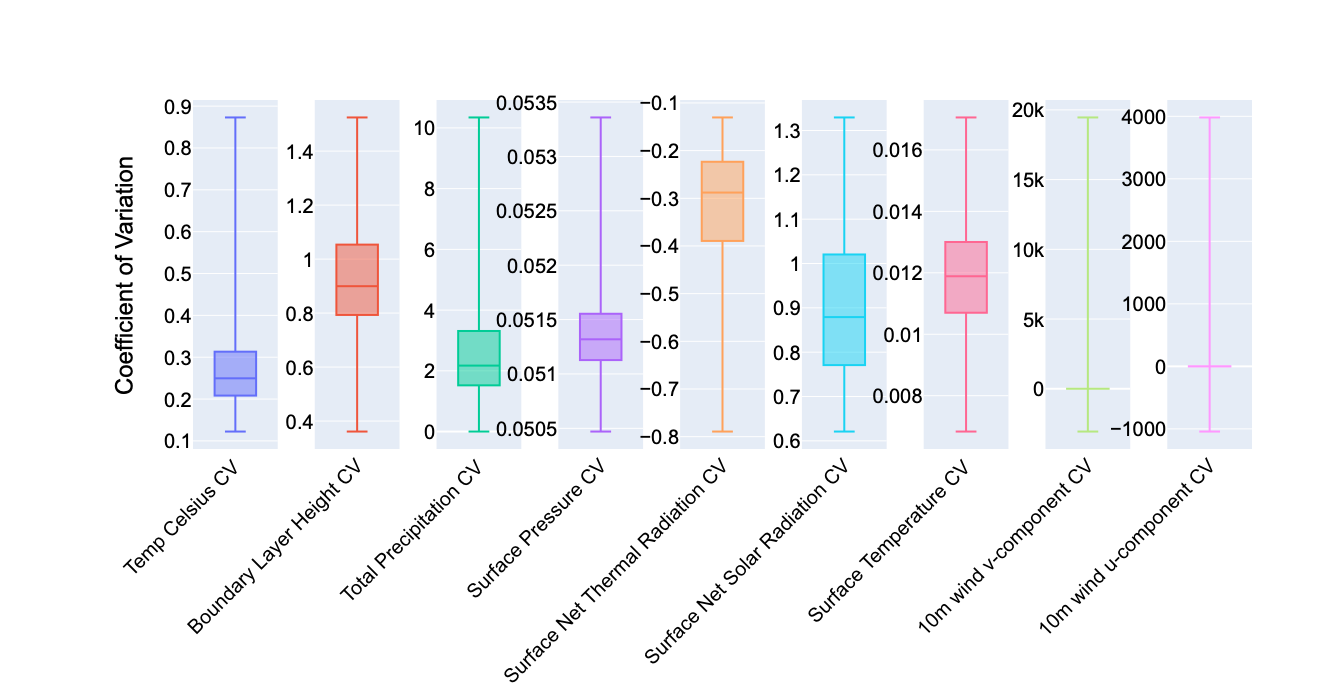

In [33]:
# Sample data preparation (assuming the rest of the data processing is done)
curr_df_era5_std = curr_df_era5.copy()
curr_df_era5_std.drop(
    columns=["time", "curr_date_y", "latitude", "longitude"],
    inplace=True,
)
curr_df_era5_std.set_index("date", inplace=True, drop=True)
curr_df_era5_std.columns = curr_df_era5_std.columns.str.replace("curr_", "")
curr_df_era5_std.columns = curr_df_era5_std.columns.str.replace("_", " ").str.title()
curr_df_era5_std.rename(
    columns={"U10": "10m wind u-component", "V10": "10m wind v-component"}, inplace=True
)

# Calculate variation metrics
variation_metrics = curr_df_era5_std.resample("D").agg(
    ["std", lambda x: x.max() - x.min(), lambda x: np.std(x) / np.mean(x)]
)
variation_metrics.columns = ["_".join(col) for col in variation_metrics.columns]

# Rename columns for clarity
variation_metrics.columns = variation_metrics.columns.str.replace(
    "<lambda_0>", "Range"
).str.replace("<lambda_1>", "CV")

# Rename columns to end with " CV" instead of "_CV"
variation_metrics.columns = variation_metrics.columns.str.replace("_CV", " CV")

# Create box plot data
cv_columns = [col for col in variation_metrics.columns if " CV" in col]
boxplot_data = (
    variation_metrics[cv_columns]
    .reset_index()
    .melt(id_vars="date", var_name="Variable", value_name="Coefficient of Variation")
)

# Create subplots
num_vars = len(cv_columns)
fig_box = sp.make_subplots(rows=1, cols=num_vars, horizontal_spacing=0.035)

# Add box plots to each subplot
for i, col in enumerate(reversed(cv_columns)):
    fig_box.add_trace(
        go.Box(
            y=boxplot_data[boxplot_data["Variable"] == col]["Coefficient of Variation"],
            name=col,
            boxpoints=False,
        ),
        row=1,
        col=i + 1,
    )

# Update layout
fig_box.update_layout(
    # title_text="Distribution of Coefficient of Variation Across Variables",
    showlegend=False,
    height=700,  # Adjust height based on the number of plots
    width=2000,
    # xaxis_title="Variable",
    yaxis_title="Coefficient of Variation",
    margin=dict(b=150),  # Increase bottom margin to accommodate rotated labels
    font=dict(
        family="Arial",  # Specify the font family
        size=20,  # Set font size larger
        color="black",  # Optional: Set font color
    ),
)
# Rotate x-axis labels for each subplot
for i in range(1, num_vars + 1):
    fig_box.update_xaxes(tickangle=-45, row=1, col=i)

fig_box.write_image(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Papers/MDPI_2024/images/coeff_variation.png",
    scale=2,
)
fig_box.show()

In [19]:
curr_df_era5_std = curr_df_era5.copy()
curr_df_era5_std["date"] = curr_df_era5_std["time"].dt.date
curr_df_era5_std.drop(
    columns=[
        "time",
        "curr_date_x",
        "curr_date_y",
    ],
    inplace=True,
)
curr_df_era5_std = curr_df_era5_std.groupby(["date", "latitude", "longitude"]).std()

curr_df_era5_std_normalised = (curr_df_era5_std - curr_df_era5_std.min()) / (
    curr_df_era5_std.max() - curr_df_era5_std.min()
)
curr_df_era5_std_normalised.columns = curr_df_era5_std_normalised.columns.str.replace(
    "curr_", ""
)
curr_df_era5_std_normalised.columns = curr_df_era5_std_normalised.columns.str.replace(
    "_", " "
).str.title()

KeyError: "['curr_date_x'] not found in axis"

In [27]:
$ pip show -U kaleido

SyntaxError: invalid syntax (2395242203.py, line 1)

ERROR:root:Cannot parse: 1:0: $ pip show -U kaleido
Traceback (most recent call last):
  File "/Users/rodrigo/miniforge3/envs/ml/lib/python3.10/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/Users/rodrigo/miniforge3/envs/ml/lib/python3.10/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "/Users/rodrigo/miniforge3/envs/ml/lib/python3.10/site-packages/black/__init__.py", line 1156, in format_str
    dst_contents = _format_str_once(src_contents, mode=mode, lines=lines)
  File "/Users/rodrigo/miniforge3/envs/ml/lib/python3.10/site-packages/black/__init__.py", line 1170, in _format_str_once
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "/Users/rodrigo/miniforge3/envs/ml/lib/python3.10/site-packages/black/parsing.py", line 89, in lib2to3_parse
    raise exc from None
black.parsing.InvalidInput: Cannot parse: 1:0: $ pip show -U kaleid

In [54]:
curr_df_era5_std_normalised

U10       V10  Surface Temperature  \
date       latitude longitude                                            
2019-01-01 19.0     -100.0     0.190702  0.378695             0.634577   
                    -99.0      0.258556  0.553505             0.743172   
           20.0     -100.0     0.171832  0.096531             0.367321   
                    -99.0      0.351567  0.138670             0.390225   
2019-01-02 19.0     -100.0     0.129049  0.389759             0.600117   
...                                 ...       ...                  ...   
2023-12-30 20.0     -99.0      0.123182  0.166524             0.349269   
2023-12-31 19.0     -100.0     0.139732  0.513613             0.691708   
                    -99.0      0.199001  0.598570             0.740845   
           20.0     -100.0     0.125075  0.078441             0.443560   
                    -99.0      0.272990  0.121448             0.434302   

                               Surface Net Solar Radiation  \
date       latitude longitude                                
2019-01-01 19.0     -100.0                        0.508333   
                    -99.0                         0.537127   
           20.0     -100.0                        0.467325   
                    -99.0                         0.494831   
2019-01-02 19.0     -100.0                        0.482637   
...                                                    ...   
2023-12-30 20.0     -99.0                         0.475865   
2023-12-31 19.0     -100.0                        0.507075   
                    -99.0                         0.520723   
           20.0     -100.0                        0.497049   
                    -99.0                         0.498387   

                               Surface Net Thermal Radiation  \
date       latitude longitude                                  
2019-01-01 19.0     -100.0                          0.241289   
                    -99.0                           0.295626   
           20.0     -100.0                          0.259614   
                    -99.0                           0.395197   
2019-01-02 19.0     -100.0                          0.245793   
...                                                      ...   
2023-12-30 20.0     -99.0                           0.392570   
2023-12-31 19.0     -100.0                          0.243343   
                    -99.0                           0.279778   
           20.0     -100.0                          0.245675   
                    -99.0                           0.275156   

                               Surface Pressure  Total Precipitation  \
date       latitude longitude                                          
2019-01-01 19.0     -100.0             0.867374             0.000000   
                    -99.0              0.975099             0.000000   
           20.0     -100.0             0.007861             0.000518   
                    -99.0              0.130823             0.001420   
2019-01-02 19.0     -100.0             0.871269             0.000000   
...                                         ...                  ...   
2023-12-30 20.0     -99.0              0.136705             0.000029   
2023-12-31 19.0     -100.0             0.881636             0.000000   
                    -99.0              0.991707             0.000000   
           20.0     -100.0             0.008808             0.000000   
                    -99.0              0.133728             0.000000   

                               Boundary Layer Height  Temp Celsius  
date       latitude longitude                                       
2019-01-01 19.0     -100.0                  0.022076      0.634577  
                    -99.0                   0.003428      0.743172  
           20.0     -100.0                  0.028514      0.367321  
                    -99.0                   0.046631      0.390226  
2019-01-02 19.0     -100.0                  0.092530      0.600117  
...          

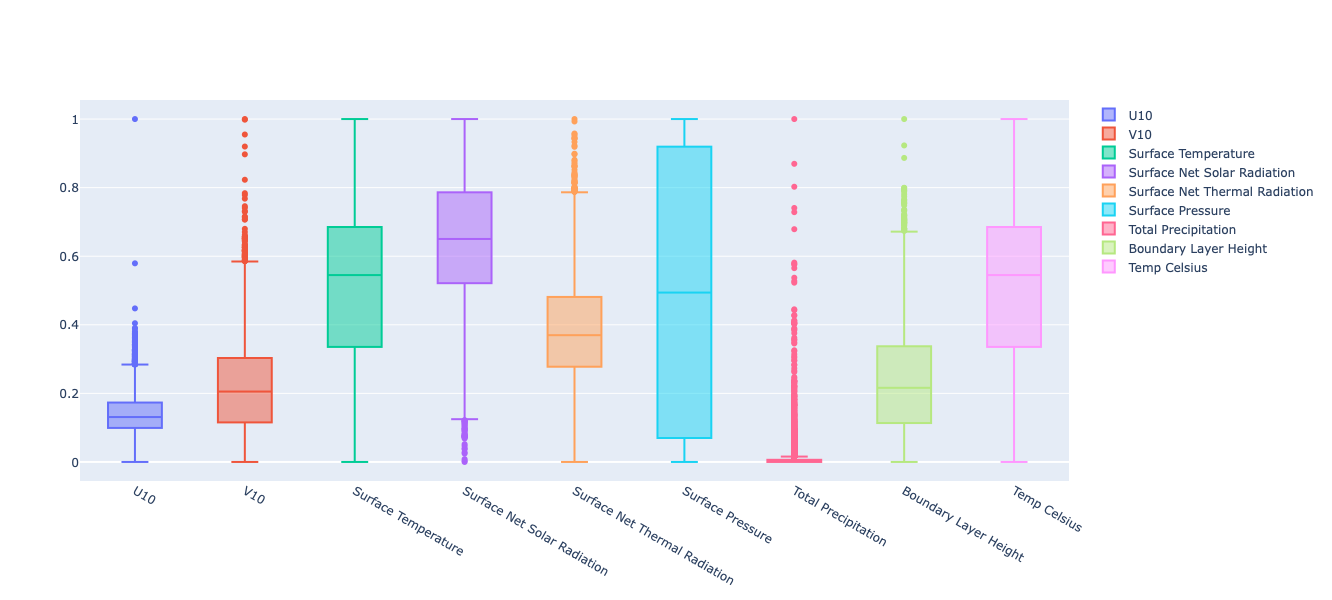

In [55]:
# Create the boxplot
fig = go.Figure()
for column in curr_df_era5_std_normalised.columns:
    fig.add_trace(
        go.Box(
            y=curr_df_era5_std_normalised[column],  # Data for the boxplot
            name=column,  # Name of the boxplot
        )
    )
# Adjust the layout to make the plot taller
fig.update_layout(height=600)  # Set the height to 600 pixels
# Show the figure
fig.show()

In [39]:
curr_df_era5_std.describe()

curr_u10     curr_v10  curr_surface_temperature  \
count  7304.000000  7304.000000               7304.000000   
mean      0.479524     0.518835                  2.827638   
std       0.166597     0.243576                  1.040449   
min       0.086808     0.095233                  0.136480   
25%       0.362350     0.315545                  1.883792   
50%       0.450332     0.487313                  2.974066   
75%       0.567726     0.674117                  3.704073   
max       2.863139     2.004839                  5.343432   

       curr_surface_net_solar_radiation  curr_surface_net_thermal_radiation  \
count                       7304.000000                         7304.000000   
mean                      422025.007475                        61325.592934   
std                       108414.232860                        21005.068947   
min                        38480.745448                         7940.411200   
25%                       347109.357366                        46725.837202   
50%                       423459.829135                        59574.077477   
75%                       503972.134672                        75147.190616   
max                       630479.965083                       147600.931079   

       curr_surface_pressure  curr_total_precipitation  \
count            7304.000000               7304.000000   
mean             2720.000975                  0.000026   
std              1794.047500                  0.000100   
min               654.554132                  0.000000   
25%              1056.303412                  0.000000   
50%              2724.386941                  0.000001   
75%              4440.083306                  0.000014   
max              4844.726197                  0.002271   

       curr_boundary_layer_height  curr_temp_celsius  
count                 7304.000000        7304.000000  
mean                   163.336573           2.827638  
std                    107.927914           1.040449  
min                      0.059428           0.136480  
25%                     76.625340           1.883792  
50%                    145.907735           2.974066  
75%                    227.667652           3.704073  
max                    674.740847           5.343432

In [40]:
cdmx_2hour_mean.describe()

curr_u10     curr_v10  curr_surface_temperature  \
count  7304.000000  7304.000000               7304.000000   
mean      0.479524     0.518835                  2.827638   
std       0.166597     0.243576                  1.040449   
min       0.086808     0.095233                  0.136480   
25%       0.362350     0.315545                  1.883792   
50%       0.450332     0.487313                  2.974066   
75%       0.567726     0.674117                  3.704073   
max       2.863139     2.004839                  5.343432   

       curr_surface_net_solar_radiation  curr_surface_net_thermal_radiation  \
count                       7304.000000                         7304.000000   
mean                      422025.007475                        61325.592934   
std                       108414.232860                        21005.068947   
min                        38480.745448                         7940.411200   
25%                       347109.357366                        46725.837202   
50%                       423459.829135                        59574.077477   
75%                       503972.134672                        75147.190616   
max                       630479.965083                       147600.931079   

       curr_surface_pressure  curr_total_precipitation  \
count            7304.000000               7304.000000   
mean             2720.000975                  0.000026   
std              1794.047500                  0.000100   
min               654.554132                  0.000000   
25%              1056.303412                  0.000000   
50%              2724.386941                  0.000001   
75%              4440.083306                  0.000014   
max              4844.726197                  0.002271   

       curr_boundary_layer_height  curr_temp_celsius  
count                 7304.000000        7304.000000  
mean                   163.336573           2.827638  
std                    107.927914           1.040449  
min                      0.059428           0.136480  
25%                     76.625340           1.883792  
50%                    145.907735           2.974066  
75%                    227.667652           3.704073  
max                    674.740847           5.343432

### Previous day dataframe

In [17]:
prev_1_df_era5 = df_era5.between_time("00:00", "12:59")
prev_2_df_era5 = df_era5.between_time("15:01", "23:59")
prev_2_df_era5 = prev_2_df_era5.shift(1, freq="D")

prev_df_era5 = pd.concat([prev_1_df_era5, prev_2_df_era5])

del df_era5
del prev_1_df_era5
del prev_2_df_era5
prev_df_era5 = prev_df_era5.add_prefix("prev_")
# prev_df_era5.set_index("prev_date", drop=True, inplace=True)
# prev_df_era5.reset_index(drop=False, inplace=True)
prev_df_era5.rename(
    columns={"prev_latitude": "latitude", "prev_longitude": "longitude"}, inplace=True
)
# prev_df_era5.drop(["prev_time"], axis=1, inplace=True)
prev_df_era5.sort_index(inplace=True)
prev_df_era5.reset_index(drop=False, inplace=True)

### Combination of current and previous dataframes

In [18]:
# curr_df_era5["date"] = pd.to_datetime(curr_df_era5["date"], format="%Y-%m-%d %H:%M:%S")
# prev_df_era5["date"] = pd.to_datetime(prev_df_era5["date"], format="%Y-%m-%d %H:%M:%S")

curr_df_era5["date"] = curr_df_era5["time"].dt.date
prev_df_era5["date"] = prev_df_era5["time"].dt.date

curr_df_era5 = curr_df_era5.groupby(["date", "latitude", "longitude"]).mean()
prev_df_era5 = prev_df_era5.groupby(["date", "latitude", "longitude"]).mean()

complete_gdf_era5 = curr_df_era5.merge(
    prev_df_era5,
    how="left",
    left_on=["date", "latitude", "longitude"],
    right_on=["date", "latitude", "longitude"],
)
# del df_era5
del curr_df_era5
del prev_df_era5
complete_gdf_era5.reset_index(inplace=True, drop=False)
complete_gdf_era5.rename(columns={"latitude": "lat", "longitude": "lng"}, inplace=True)
complete_gdf_era5.drop(columns=["time_y"], inplace=True)
complete_gdf_era5.rename(columns={"time_x": "time"})

date   lat    lng                time  curr_u10  curr_v10  \
0     2019-01-01  19.0 -100.0 2019-01-01 14:00:00 -0.155381 -0.236818   
1     2019-01-01  19.0  -99.0 2019-01-01 14:00:00 -0.251902 -0.295797   
2     2019-01-01  20.0 -100.0 2019-01-01 14:00:00  0.547500  1.252588   
3     2019-01-01  20.0  -99.0 2019-01-01 14:00:00 -0.738504  0.945980   
4     2019-01-02  19.0 -100.0 2019-01-02 14:00:00 -0.188945 -0.177904   
...          ...   ...    ...                 ...       ...       ...   
7299  2023-12-30  20.0  -99.0 2023-12-30 14:00:00 -0.691767  0.353577   
7300  2023-12-31  19.0 -100.0 2023-12-31 14:00:00 -0.169196 -0.162653   
7301  2023-12-31  19.0  -99.0 2023-12-31 14:00:00 -0.118119 -0.215515   
7302  2023-12-31  20.0 -100.0 2023-12-31 14:00:00  0.470984  1.434990   
7303  2023-12-31  20.0  -99.0 2023-12-31 14:00:00 -0.397590  1.381014   

      curr_surface_temperature  curr_surface_net_solar_radiation  \
0                   281.098755                      296927.25000   
1                   281.953735                      322679.03125   
2                   279.408203                      266493.09375   
3                   279.586578                      292374.78125   
4                   281.650604                      283363.87500   
...                        ...                               ...   
7299                278.314423                      283365.00000   
7300                278.502045                      297320.09375   
7301                279.766235                      315529.90625   
7302                276.374542                      283721.09375   
7303                277.607330                      298297.78125   

      curr_surface_net_thermal_radiation  curr_surface_pressure  ...  \
0                          -287922.31250           76838.585938  ...   
1                          -322363.43750           78464.695312  ...   
2                          -248343.56250           74392.101562  ...   
3                          -302044.21875           76119.289062  ...   
4                          -270172.40625           76982.414062  ...   
...                                  ...                    ...  ...   
7299                       -293139.75000           76489.695312  ...   
7300                       -289421.34375           77205.609375  ...   
7301                       -311028.46875           78859.492188  ...   
7302                       -300231.78125           74712.429688  ...   
7303                       -322091.81250           76459.984375  ...   

      prev_v10 prev_surface_temperature  prev_surface_net_solar_radiation  \
0     0.007116               283.499084                      22411.300781   
1    -0.078442               284.560852                      19025.498047   
2     0.495331               282.184174                      19954.115234   
3     0.193774               283.481018                      16142.503906   
4     0.709486               286.458618                     767841.062500   
...        ...                      ...                               ...   
7299 -0.787232               282.896332                     677502.625000   
7300  0.550820               284.108459                     720351.687500   
7301  0.535230               285.663330                     693715.000000   
7302  0.194663               282.179382                     722710.250000   
7303 -0.093054               283.869659                     686852.812500   

     prev_surface_net_thermal_radiation  prev_surface_pressure  \
0                        -251800.515625           76793.351562   
1                        -294006.625000           78415.421875   
2                        -239641.468750           74361.484375   
3                        -290871.968750           76070.140625   
4                        -353066.656250           76798.695312   
...                                 ...                    ...   
7299                     -302531.718750           76321.679688   


In [19]:
complete_gdf_era5.set_index(["date"], inplace=True, drop=True)
complete_gdf_era5["curr_wind_dir"] = np.rad2deg(
    np.arctan2(complete_gdf_era5["curr_v10"], complete_gdf_era5["curr_u10"])
)
complete_gdf_era5["curr_wind_speed"] = np.sqrt(
    complete_gdf_era5["curr_v10"] ** 2 + complete_gdf_era5["curr_u10"] ** 2
)
complete_gdf_era5["curr_wind_dir"] = np.where(
    complete_gdf_era5["curr_wind_dir"] < 0,
    complete_gdf_era5["curr_wind_dir"] + 360,
    complete_gdf_era5["curr_wind_dir"],
)

complete_gdf_era5["prev_wind_dir"] = np.rad2deg(
    np.arctan2(complete_gdf_era5["prev_v10"], complete_gdf_era5["prev_u10"])
)
complete_gdf_era5["prev_wind_speed"] = np.sqrt(
    complete_gdf_era5["prev_v10"] ** 2 + complete_gdf_era5["prev_u10"] ** 2
)
complete_gdf_era5["prev_wind_dir"] = np.where(
    complete_gdf_era5["prev_wind_dir"] < 0,
    complete_gdf_era5["prev_wind_dir"] + 360,
    complete_gdf_era5["prev_wind_dir"],
)

"""complete_gdf_era5 = complete_gdf_era5[
    [
        "lat",
        "lng",
        "curr_temp_celsius",
        "curr_surface_net_solar_radiation",
        "curr_surface_net_thermal_radiation",
        "curr_surface_pressure",
        "curr_total_precipitation",
        "curr_wind_dir",
        "curr_wind_speed",
        "curr_boundary_layer_height",
        "prev_temp_celsius",
        "prev_surface_net_solar_radiation",
        "prev_surface_net_thermal_radiation",
        "prev_surface_pressure",
        "prev_total_precipitation",
        "prev_wind_dir",
        "prev_wind_speed",
        "prev_boundary_layer_height",
    ]
]"""

# complete_gdf_era5.to_csv("/Volumes/Rodrigo_2TB/CDMX/Dataframes/df-era5-cdmx.csv")
complete_gdf_era5

lat    lng              time_x  curr_u10  curr_v10  \
date                                                              
2019-01-01  19.0 -100.0 2019-01-01 14:00:00 -0.155381 -0.236818   
2019-01-01  19.0  -99.0 2019-01-01 14:00:00 -0.251902 -0.295797   
2019-01-01  20.0 -100.0 2019-01-01 14:00:00  0.547500  1.252588   
2019-01-01  20.0  -99.0 2019-01-01 14:00:00 -0.738504  0.945980   
2019-01-02  19.0 -100.0 2019-01-02 14:00:00 -0.188945 -0.177904   
...          ...    ...                 ...       ...       ...   
2023-12-30  20.0  -99.0 2023-12-30 14:00:00 -0.691767  0.353577   
2023-12-31  19.0 -100.0 2023-12-31 14:00:00 -0.169196 -0.162653   
2023-12-31  19.0  -99.0 2023-12-31 14:00:00 -0.118119 -0.215515   
2023-12-31  20.0 -100.0 2023-12-31 14:00:00  0.470984  1.434990   
2023-12-31  20.0  -99.0 2023-12-31 14:00:00 -0.397590  1.381014   

            curr_surface_temperature  curr_surface_net_solar_radiation  \
date                                                                     
2019-01-01                281.098755                      296927.25000   
2019-01-01                281.953735                      322679.03125   
2019-01-01                279.408203                      266493.09375   
2019-01-01                279.586578                      292374.78125   
2019-01-02                281.650604                      283363.87500   
...                              ...                               ...   
2023-12-30                278.314423                      283365.00000   
2023-12-31                278.502045                      297320.09375   
2023-12-31                279.766235                      315529.90625   
2023-12-31                276.374542                      283721.09375   
2023-12-31                277.607330                      298297.78125   

            curr_surface_net_thermal_radiation  curr_surface_pressure  \
date                                                                    
2019-01-01                       -287922.31250           76838.585938   
2019-01-01                       -322363.43750           78464.695312   
2019-01-01                       -248343.56250           74392.101562   
2019-01-01                       -302044.21875           76119.289062   
2019-01-02                       -270172.40625           76982.414062   
...                                        ...                    ...   
2023-12-30                       -293139.75000           76489.695312   
2023-12-31                       -289421.34375           77205.609375   
2023-12-31                       -311028.46875           78859.492188   
2023-12-31                       -300231.78125           74712.429688   
2023-12-31                       -322091.81250           76459.984375   

            curr_total_precipitation  ... prev_surface_pressure  \
date                                  ...                         
2019-01-01              0.000000e+00  ...          76793.351562   
2019-01-01              0.000000e+00  ...          78415.421875   
2019-01-01              4.899533e-07  ...          74361.484375   
2019-01-01              1.194150e-06  ...          76070.140625   
2019-01-02              0.000000e+00  ...          76798.695312   
...                              ...  ...                   ...   
2023-12-30              1.327135e-08  ...          76321.679688   
2023-12-31              0.000000e+00  ...          77139.960938   
2023-12-31              0.000000e+00  ...          78782.359375   
2023-12-31              0.000000e+00  ...          74669.843750   
2023-12-31              0.000000e+00  ...          76400.187500   

            prev_total_precipitation                   prev_date_x  \
date                                                                 
2019-01-01              0.000000e+00 2019-01-01 00:00:00.000000000   
2019-01-01              0.000000e+00 2019-01-01 00:00:00.000000000   
2019-01-01              0.000000e+00 2019-01-01 00:00:00.000000000   
2019-0

# Create table with nearest points

In [20]:
cdmx_no2 = gpd.GeoDataFrame(
    cdmx_no2, geometry=gpd.points_from_xy(cdmx_no2["lng"], cdmx_no2["lat"])
)

complete_gdf_era5 = gpd.GeoDataFrame(
    complete_gdf_era5,
    geometry=gpd.points_from_xy(complete_gdf_era5["lng"], complete_gdf_era5["lat"]),
)

S5P_gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
cdmx_no2.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
complete_gdf_era5.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

S5P_gdf = S5P_gdf.to_crs(epsg=3857)
cdmx_no2 = cdmx_no2.to_crs(epsg=3857)
complete_gdf_era5 = complete_gdf_era5.to_crs(epsg=3857)

S5P_gdf.reset_index(drop=False, inplace=True)
S5P_gdf["date"] = S5P_gdf["date"].dt.date
S5P_gdf = S5P_gdf.groupby(["date", "geometry"]).mean()

cdmx_no2 = cdmx_no2.between_time("19:00", "21:00")
cdmx_no2.reset_index(drop=False, inplace=True)
cdmx_no2["date"] = cdmx_no2["date"].dt.date
cdmx_no2 = cdmx_no2.groupby(["date", "station", "geometry"]).mean()

complete_gdf_era5.reset_index(drop=False, inplace=True)
complete_gdf_era5 = complete_gdf_era5.groupby(["date", "geometry"]).mean()
S5P_gdf.reset_index(drop=False, inplace=True)
S5P_gdf.drop(columns=["index"])
cdmx_no2.reset_index(drop=False, inplace=True)
complete_gdf_era5.reset_index(drop=False, inplace=True)

In [21]:
unique_stations = cdmx_no2[["station", "geometry"]]
unique_stations = unique_stations.groupby(["station", "geometry"]).mean()
unique_stations.reset_index(inplace=True, drop=False)
unique_stations = gpd.GeoDataFrame(unique_stations)
unique_stations = unique_stations.set_crs(epsg=3857)

unique_stations["sat_nearest_point"] = "nan"
unique_stations["gr_sat_distance"] = np.nan
unique_stations["era5_nearest_point"] = "nan"
unique_stations["gr_era5_distance"] = np.nan

closest_sat_point = -9999
closest_era5_point = -9999

for no2_ind in range(0, len(unique_stations)):
    no2_point = unique_stations["geometry"][no2_ind]
    min_points_dist_sat = 9e5000
    min_points_dist_era5 = 9e5000

    for sat_point in S5P_gdf["geometry"].unique():
        dist_points_sat = no2_point.distance(sat_point)
        if dist_points_sat < min_points_dist_sat:
            min_points_dist_sat = dist_points_sat
            closest_sat_point = sat_point

    for era5_point in complete_gdf_era5["geometry"].unique():
        dist_points_era5 = no2_point.distance(era5_point)
        if dist_points_era5 < min_points_dist_era5:
            min_points_dist_era5 = dist_points_era5
            closest_era5_point = era5_point

    unique_stations.loc[no2_ind, "sat_nearest_point"] = closest_sat_point
    unique_stations.loc[no2_ind, "gr_sat_distance"] = min_points_dist_sat

    unique_stations.loc[no2_ind, "era5_nearest_point"] = closest_era5_point
    unique_stations.loc[no2_ind, "gr_era5_distance"] = min_points_dist_era5

In [22]:
unique_stations

station                           geometry  \
0      ACO  POINT (-11006714.652 2228659.542)   
1      AJM  POINT (-11041501.993 2186234.054)   
2      ATI  POINT (-11048459.461 2224966.628)   
3      BJU  POINT (-11041501.993 2199136.228)   
4      CAM  POINT (-11041501.993 2212047.067)   
5      CCA  POINT (-11041501.993 2193605.668)   
6      CHO  POINT (-11006714.652 2186234.054)   
7      CUA  POINT (-11055416.929 2199136.228)   
8      CUT  POINT (-11041501.993 2228659.542)   
9      FAC  POINT (-11048459.461 2212047.067)   
10     FAR  POINT (-11027587.057 2212047.067)   
11     GAM  POINT (-11027587.057 2212047.067)   
12     HGM  POINT (-11041501.993 2202824.153)   
13     IZT  POINT (-11034544.525 2199136.228)   
14     LLA  POINT (-11027587.057 2224966.628)   
15     MER  POINT (-11034544.525 2202824.153)   
16     MGH  POINT (-11041501.993 2202824.153)   
17     MON  POINT (-11006714.652 2208357.368)   
18     MPA  POINT (-11020629.589 2177023.488)   
19     NEZ  POINT (-11020629.589 2202824.153)   
20     PED  POINT (-11041501.993 2193605.668)   
21     SAC  POINT (-11020629.589 2193605.668)   
22     SAG  POINT (-11027587.057 2215737.477)   
23     SFE  POINT (-11048459.461 2199136.228)   
24     TAH  POINT (-11020629.589 2186234.054)   
25     TLA  POINT (-11041501.993 2215737.477)   
26     TLI  POINT (-11041501.993 2224966.628)   
27     UAX  POINT (-11034544.525 2189919.509)   
28     UIZ  POINT (-11027587.057 2199136.228)   
29     VIF  POINT (-11027587.057 2228659.542)   
30     XAL  POINT (-11027587.057 2215737.477)   

                                 sat_nearest_point  gr_sat_distance  \
0   POINT (-11003931.664915094 2229486.8529178863)      2903.353541   
1    POINT (-11044006.681600671 2187929.276048484)      3024.440747   
2   POINT (-11050685.851048267 2225705.1534627834)      2345.683546   
3    POINT (-11044006.681600671 2199254.230888332)      2507.466712   
4   POINT (-11044006.681600671 2210585.8609703095)      2899.756329   
5   POINT (-11044006.681600671 2195478.5062066833)      3127.457309   
6    POINT (-11003931.664915094 2187929.276048484)      3258.649303   
7    POINT (-11057365.020495864 2199254.230888332)      1951.661730   
8   POINT (-11044006.681600671 2229486.8529178863)      2637.784740   
9   POINT (-11050685.851048267 2210585.8609703095)      2663.068471   
10  POINT (-11030648.342705479 2210585.8609703095)      3392.137088   
11  POINT (-11030648.342705479 2210585.8609703095)      3392.137088   
12  POINT (-11044006.681600671 2203030.6972626634)      2513.190285   
13   POINT (-11037327.512153074 2199254.230888332)      2785.487886   
14  POINT (-11030648.342705479 2225705.1534627834)      3149.109659   
15  POINT (-11037327.512153074 2203030.6972626634)      2790.641299   
16  POINT (-11044006.681600671 2203030.6972626634)      2513.190285   
17  POINT (-11003931.664915094 2206807.9067995795)      3185.254879   
18  POINT (-11017290.003810285 2176610.9568350525)      3364.967744   
19  POINT (-11023969.173257882 2203030.6972626634)      3345.965756   
20  POINT (-11044006.681600671 2195478.5062066833)      3127.457309   
21  POINT (-11017290.003810285 2195478.5062066833)      3828.883734   
22  POINT (-11030648.342705479 2214364.5612474196)      3355.051461   
23   POINT (-11050685.851048267 2199254.230888332)      2229.514797   
24   POINT (-11023969.173257882 2187929.276048484)      3745.210710   
25  POINT (-11044006.681600671 2214364.5612474196)      2856.284834   
26  POINT (-11044006.681600671 2225705.1534627834)      2611.299367   
27    POINT (-11037327.512153074 2191703.52174915)      3305.710182   
28   POINT (-11030648.342705479 2199254.230888332)      3063.559461   
29  POINT (-11030648.342705479 2229486.8529178863)      3171.106367   
30  POINT (-11030648.342705479 2214364.5612474196)      3355.051461   

                                era5_nearest_point  gr_era5_distance  
0   POINT (-11020629.588534083 2273030.9269876895)      46502.099679  
1    POINT (-110206

In [23]:
S5P_gdf_merge = S5P_gdf.merge(
    unique_stations[["station", "sat_nearest_point"]],
    left_on="geometry",
    right_on="sat_nearest_point",
    suffixes=("", "drop"),
)

del S5P_gdf

S5P_gdf_merge = S5P_gdf_merge[
    [col for col in S5P_gdf_merge.columns if not col.endswith("_drop")]
]

complete_gdf_era5_merge = complete_gdf_era5.merge(
    unique_stations[["station", "era5_nearest_point"]],
    left_on="geometry",
    right_on="era5_nearest_point",
    suffixes=("", "drop"),
)
del complete_gdf_era5
complete_gdf_era5_merge = complete_gdf_era5_merge[
    [col for col in complete_gdf_era5_merge.columns if not col.endswith("_drop")]
]

S5P_gdf_merge = S5P_gdf_merge[["date", "geometry", "station", "satellite_no2"]]
complete_gdf_era5_merge = complete_gdf_era5_merge[
    [
        "date",
        "geometry",
        "station",
        "curr_temp_celsius",
        "curr_surface_net_solar_radiation",
        "curr_surface_net_thermal_radiation",
        "curr_surface_pressure",
        "curr_total_precipitation",
        "curr_wind_dir",
        "curr_wind_speed",
        "curr_boundary_layer_height",
        "prev_temp_celsius",
        "prev_surface_net_solar_radiation",
        "prev_surface_net_thermal_radiation",
        "prev_surface_pressure",
        "prev_total_precipitation",
        "prev_wind_dir",
        "prev_wind_speed",
        "prev_boundary_layer_height",
    ]
]
S5P_gdf_merge.dropna(axis=0, inplace=True)
complete_gdf_era5_merge.dropna(axis=0, inplace=True)

In [24]:
cdmx_df_complete = cdmx_no2.merge(
    S5P_gdf_merge,
    left_on=["date", "station"],
    right_on=["date", "station"],
    suffixes=("", "_drop"),
)
del cdmx_no2
cdmx_df_complete = cdmx_df_complete[
    [col for col in cdmx_df_complete.columns if not col.endswith("_drop")]
]
cdmx_df_complete = cdmx_df_complete.merge(
    complete_gdf_era5_merge,
    left_on=["date", "station"],
    right_on=["date", "station"],
    suffixes=("", "_drop"),
)
del complete_gdf_era5_merge
cdmx_df_complete = cdmx_df_complete[
    [col for col in cdmx_df_complete.columns if not col.endswith("_drop")]
]
cdmx_df_complete.drop(columns=["lat", "lng"], inplace=True)
cdmx_df_complete.dropna(axis=0, inplace=True)
cdmx_df_complete.set_index("date", inplace=True)

In [25]:
cdmx_df_complete

station                           geometry  ground_no2  \
date                                                                
2019-01-01     ACO  POINT (-11006714.652 2228659.542)   27.333334   
2019-01-01     AJM  POINT (-11041501.993 2186234.054)   10.000000   
2019-01-01     ATI  POINT (-11048459.461 2224966.628)   25.666666   
2019-01-01     BJU  POINT (-11041501.993 2199136.228)   32.333332   
2019-01-01     CAM  POINT (-11041501.993 2212047.067)   41.000000   
...            ...                                ...         ...   
2023-01-03     SAG  POINT (-11027587.057 2215737.477)   43.000000   
2023-01-03     TAH  POINT (-11020629.589 2186234.054)   29.666666   
2023-01-03     TLA  POINT (-11041501.993 2215737.477)   24.333334   
2023-01-03     UIZ  POINT (-11027587.057 2199136.228)   32.333332   
2023-01-03     VIF  POINT (-11027587.057 2228659.542)   35.333332   

            satellite_no2  curr_temp_celsius  \
date                                           
2019-01-01       0.000041           6.436559   
2019-01-01       0.000090           8.803738   
2019-01-01       0.000115           6.436559   
2019-01-01       0.000146           8.803738   
2019-01-01       0.000210           8.803738   
...                   ...                ...   
2023-01-03       0.000158           9.022840   
2023-01-03       0.000140          11.108898   
2023-01-03       0.000098           9.022840   
2023-01-03       0.000168          11.108898   
2023-01-03       0.000103           9.022840   

            curr_surface_net_solar_radiation  \
date                                           
2019-01-01                      292374.78125   
2019-01-01                      322679.03125   
2019-01-01                      292374.78125   
2019-01-01                      322679.03125   
2019-01-01                      322679.03125   
...                                      ...   
2023-01-03                      266844.00000   
2023-01-03                      267415.78125   
2023-01-03                      266844.00000   
2023-01-03                      267415.78125   
2023-01-03                      266844.00000   

            curr_surface_net_thermal_radiation  curr_surface_pressure  \
date                                                                    
2019-01-01                      -302044.218750           76119.289062   
2019-01-01                      -322363.437500           78464.695312   
2019-01-01                      -302044.218750           76119.289062   
2019-01-01                      -322363.437500           78464.695312   
2019-01-01                      -322363.437500           78464.695312   
...                                        ...                    ...   
2023-01-03                      -277615.343750           76380.140625   
2023-01-03                      -250948.421875           78789.148438   
2023-01-03                      -277615.343750           76380.140625   
2023-01-03                      -250948.421875           78789.148438   
2023-01-03                      -277615.343750           76380.140625   

            curr_total_precipitation  curr_wind_dir  curr_wind_speed  \
date                                                                   
2019-01-01                  0.000001     127.978310         1.200111   
2019-01-01                  0.000000     229.582169         0.388524   
2019-01-01                  0.000001     127.978310         1.200111   
2019-01-01                  0.000000     229.582169         0.388524   
2019-01-01                  0.000000     229.582169         0.388524   
...                              ...            ...              ...   
2023-01-03                  0.000000     104.602692         1.972722   
2023-01-03                  0.000000     147.447861         0.314430   
2023-01-03                  0.000000     104.602692         1.972722   
2023-01-03                  0.000000     147.447861         0.314430   
2023-01-03                  0.000000     104.6026

# Month and Days Columns

# Wind Sectors

In [26]:
# Change wind direction to sectors, variables: "Direzione Vento_curr","Direzione Vento_prev"
def add_wind_sectors(parameter, df, no_sectors):
    if no_sectors == 8 or no_sectors == 4:
        output_df = df.copy()
        interval = 360 / no_sectors
        # print(interval)
        """
        if 4 sectors:
        North 315 - 45 -> sector 1
        East 45-135 -> sector 2
        South 135 - 225 -> sector 3
        West 225-315 -> sector 4

        if 8 sectors:
        North 337.5 - 22.5 -> sector 1
        NE 22.5 - 67.5 -> sector 2
        East 67.5 - 112.5 -> sector 3
        SE 112.5 - 157.5 -> sector 4
        South 157.5 - 202.5 -> sector 5
        SW 202.5 - 247.5 -> sector 6
        West 247.5 - 292.5 -> sector 7
        NW 292.5 - 337.5 -> sector 8
        """
        for i in range(no_sectors):
            upper_b = interval * (i + 1) - interval / 2
            lower_b = interval * i - interval / 2
            if lower_b < 0:
                lower_b = 360 + lower_b
                mask = (output_df[parameter] > (lower_b)) | (
                    output_df[parameter] <= (upper_b)
                )
            else:
                mask = (output_df[parameter] > (lower_b)) & (
                    output_df[parameter] <= (upper_b)
                )
            # print('lower bound = ' + str(lower_b))
            # print('upper bound = ' + str(upper_b))
            output_df[parameter].loc[mask] = i + 1
        return output_df
    else:
        return "please provide a valid number of sectors (4 or 8)"

# Elevation

elev_xr_1 = rio.open_rasterio(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/Elevation/n45_e008_1arc_v3.tif"
)
elev_xr_2 = rio.open_rasterio(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/Elevation/n45_e009_1arc_v3.tif"
)

In [27]:
elev_pd = rio.open_rasterio(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/DEM/CDMX_GMTED2010N10W120_075/10n120w_20101117_gmted_mea075.tif"
)
elev_pd = elev_pd[0].to_pandas()
elev_pd = elev_pd.melt(ignore_index=False)
elev_pd = elev_pd.reset_index(drop=False)

# Convert all float64 columns to float16
float64_cols = elev_pd.select_dtypes(include=["float64"]).columns
elev_pd[float64_cols] = elev_pd[float64_cols].astype("float32")

print("Reducing area size...")
elev_pd = elev_pd[
    (elev_pd["y"] >= cdmx.bounds["miny"][0])
    & (elev_pd["y"] <= cdmx.bounds["maxy"][0])
    & (elev_pd["x"] >= cdmx.bounds["minx"][0])
    & (elev_pd["x"] <= cdmx.bounds["maxx"][0])
]

print("Transofrming to Geopandas…")
elev_gpd = gpd.GeoDataFrame(
    elev_pd, geometry=gpd.points_from_xy(elev_pd["x"], elev_pd["y"])
)
del elev_pd
print("Defining CRS…")
elev_gpd.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

print("Changing column names…")
# elev_gpd = elev_gpd.to_crs(epsg=3857)
elev_gpd = elev_gpd[["value", "geometry"]]
elev_gpd.rename(columns={"value": "elevation"})
elev_gpd.reset_index(inplace=True, drop=True)
elev_gpd

print("Clipping to CDMX...")
elev_gpd = gpd.clip(elev_gpd, cdmx.geometry[0])
print("Changing CRS to EPSG:3857…")
elev_gpd = elev_gpd.to_crs(epsg=3857)
print("COMPLETE!")
elev_gpd

Reducing area size...
Transofrming to Geopandas…
Defining CRS…
Changing column names…
Clipping to CDMX...
Changing CRS to EPSG:3857…
COMPLETE!


value                           geometry
130485   3239  POINT (-11037459.324 2165592.139)
115795   3021  POINT (-11043720.365 2166082.851)
118515   3059  POINT (-11042561.071 2166082.851)
117971   3047  POINT (-11042792.930 2166082.851)
116883   3052  POINT (-11043256.648 2166082.851)
...       ...                                ...
168103   2414  POINT (-11021224.948 2279308.921)
170278   2426  POINT (-11020297.512 2279555.745)
170821   2440  POINT (-11020065.653 2279802.798)
170277   2437  POINT (-11020297.512 2279802.798)
170820   2453  POINT (-11020065.653 2280049.629)

[155943 rows x 2 columns]

In [28]:
unique_stations["elev_nearest_point"] = "nan"
unique_stations["gr_elev_distance"] = np.nan
for no2_ind in range(0, len(unique_stations)):
    no2_point = unique_stations["geometry"][no2_ind]
    min_points_dist = 9e20
    for elev_point in elev_gpd["geometry"].unique():
        dist_points = no2_point.distance(elev_point)
        if dist_points < min_points_dist:
            min_points_dist = dist_points
            closest_elev_point = elev_point
    unique_stations.loc[no2_ind, "elev_nearest_point"] = closest_elev_point
    unique_stations.loc[no2_ind, "gr_elev_distance"] = min_points_dist

unique_stations

station                           geometry  \
0      ACO  POINT (-11006714.652 2228659.542)   
1      AJM  POINT (-11041501.993 2186234.054)   
2      ATI  POINT (-11048459.461 2224966.628)   
3      BJU  POINT (-11041501.993 2199136.228)   
4      CAM  POINT (-11041501.993 2212047.067)   
5      CCA  POINT (-11041501.993 2193605.668)   
6      CHO  POINT (-11006714.652 2186234.054)   
7      CUA  POINT (-11055416.929 2199136.228)   
8      CUT  POINT (-11041501.993 2228659.542)   
9      FAC  POINT (-11048459.461 2212047.067)   
10     FAR  POINT (-11027587.057 2212047.067)   
11     GAM  POINT (-11027587.057 2212047.067)   
12     HGM  POINT (-11041501.993 2202824.153)   
13     IZT  POINT (-11034544.525 2199136.228)   
14     LLA  POINT (-11027587.057 2224966.628)   
15     MER  POINT (-11034544.525 2202824.153)   
16     MGH  POINT (-11041501.993 2202824.153)   
17     MON  POINT (-11006714.652 2208357.368)   
18     MPA  POINT (-11020629.589 2177023.488)   
19     NEZ  POINT (-11020629.589 2202824.153)   
20     PED  POINT (-11041501.993 2193605.668)   
21     SAC  POINT (-11020629.589 2193605.668)   
22     SAG  POINT (-11027587.057 2215737.477)   
23     SFE  POINT (-11048459.461 2199136.228)   
24     TAH  POINT (-11020629.589 2186234.054)   
25     TLA  POINT (-11041501.993 2215737.477)   
26     TLI  POINT (-11041501.993 2224966.628)   
27     UAX  POINT (-11034544.525 2189919.509)   
28     UIZ  POINT (-11027587.057 2199136.228)   
29     VIF  POINT (-11027587.057 2228659.542)   
30     XAL  POINT (-11027587.057 2215737.477)   

                                 sat_nearest_point  gr_sat_distance  \
0   POINT (-11003931.664915094 2229486.8529178863)      2903.353541   
1    POINT (-11044006.681600671 2187929.276048484)      3024.440747   
2   POINT (-11050685.851048267 2225705.1534627834)      2345.683546   
3    POINT (-11044006.681600671 2199254.230888332)      2507.466712   
4   POINT (-11044006.681600671 2210585.8609703095)      2899.756329   
5   POINT (-11044006.681600671 2195478.5062066833)      3127.457309   
6    POINT (-11003931.664915094 2187929.276048484)      3258.649303   
7    POINT (-11057365.020495864 2199254.230888332)      1951.661730   
8   POINT (-11044006.681600671 2229486.8529178863)      2637.784740   
9   POINT (-11050685.851048267 2210585.8609703095)      2663.068471   
10  POINT (-11030648.342705479 2210585.8609703095)      3392.137088   
11  POINT (-11030648.342705479 2210585.8609703095)      3392.137088   
12  POINT (-11044006.681600671 2203030.6972626634)      2513.190285   
13   POINT (-11037327.512153074 2199254.230888332)      2785.487886   
14  POINT (-11030648.342705479 2225705.1534627834)      3149.109659   
15  POINT (-11037327.512153074 2203030.6972626634)      2790.641299   
16  POINT (-11044006.681600671 2203030.6972626634)      2513.190285   
17  POINT (-11003931.664915094 2206807.9067995795)      3185.254879   
18  POINT (-11017290.003810285 2176610.9568350525)      3364.967744   
19  POINT (-11023969.173257882 2203030.6972626634)      3345.965756   
20  POINT (-11044006.681600671 2195478.5062066833)      3127.457309   
21  POINT (-11017290.003810285 2195478.5062066833)      3828.883734   
22  POINT (-11030648.342705479 2214364.5612474196)      3355.051461   
23   POINT (-11050685.851048267 2199254.230888332)      2229.514797   
24   POINT (-11023969.173257882 2187929.276048484)      3745.210710   
25  POINT (-11044006.681600671 2214364.5612474196)      2856.284834   
26  POINT (-11044006.681600671 2225705.1534627834)      2611.299367   
27    POINT (-11037327.512153074 2191703.52174915)      3305.710182   
28   POINT (-11030648.342705479 2199254.230888332)      3063.559461   
29  POINT (-11030648.342705479 2229486.8529178863)      3171.106367   
30  POINT (-11030648.342705479 2214364.5612474196)      3355.051461   

                                era5_nearest_point  gr_era5_distance  \
0   POINT (-11020629.588534083 2273030.9269876895)      46502.099679   
1    POINT (-1102

In [29]:
elev_nearest_point = list(unique_stations["elev_nearest_point"].values)
gdf_elev_cdmx = elev_gpd[elev_gpd["geometry"].isin(elev_nearest_point)]

gdf_elev_cdmx["id"] = 0
for point in gdf_elev_cdmx["geometry"].unique():
    id_st = unique_stations["station"][
        unique_stations["gr_elev_distance"]
        == (
            unique_stations[(unique_stations["elev_nearest_point"] == point)][
                "gr_elev_distance"
            ].min()
        )
    ].values[0]
    gdf_elev_cdmx.loc[gdf_elev_cdmx["geometry"] == point, "id"] = id_st

gdf_elev_cdmx = gdf_elev_cdmx[["value", "id"]]
gdf_elev_cdmx.rename(columns={"value": "elevation"}, inplace=True)

In [30]:
gdf_elev_cdmx.rename(columns={"value": "elevation"}, inplace=True)

In [31]:
cdmx_df_complete.reset_index(drop=False, inplace=True)

# Land Use

In [32]:
# Function to read a TIFF file and convert it to a pandas DataFrame
def tiff_to_dataframe(tiff_path):
    with rasterio.open(tiff_path) as src:
        band = src.read(1)  # Read the first band

        # Get the coordinates
        rows, cols = np.meshgrid(
            np.arange(band.shape[0]), np.arange(band.shape[1]), indexing="ij"
        )
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)

        # Flatten the arrays and create a DataFrame
        data = {
            "x": np.array(xs).flatten(),
            "y": np.array(ys).flatten(),
            "value": band.flatten(),
        }
        df = pd.DataFrame(data)
    return df

In [33]:
tiff_path = "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/LU/globalIntraUrbanLanduse_CDMX.tif"
land_use = tiff_to_dataframe(tiff_path)

print("Transofrming to Geopandas…")
land_use = gpd.GeoDataFrame(
    land_use, geometry=gpd.points_from_xy(land_use["x"], land_use["y"])
)

print("Defining CRS…")
land_use.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
print("Changing CRS to EPSG:3857…")
lu_gpd = land_use.to_crs(epsg=3857)
print("COMPLETE")

Transofrming to Geopandas…
Defining CRS…
Changing CRS to EPSG:3857…
COMPLETE


In [34]:
unique_stations["lu_nearest_point"] = "nan"
unique_stations["gr_lu_distance"] = np.nan
for no2_ind in range(0, len(unique_stations)):
    no2_point = unique_stations["geometry"][no2_ind]
    min_points_dist = 9e20
    for lu_point in lu_gpd["geometry"].unique():
        dist_points = no2_point.distance(lu_point)
        if dist_points < min_points_dist:
            min_points_dist = dist_points
            closest_lu_point = lu_point
    unique_stations.loc[no2_ind, "lu_nearest_point"] = closest_lu_point
    unique_stations.loc[no2_ind, "gr_lu_distance"] = min_points_dist

unique_stations

station                           geometry  \
0      ACO  POINT (-11006714.652 2228659.542)   
1      AJM  POINT (-11041501.993 2186234.054)   
2      ATI  POINT (-11048459.461 2224966.628)   
3      BJU  POINT (-11041501.993 2199136.228)   
4      CAM  POINT (-11041501.993 2212047.067)   
5      CCA  POINT (-11041501.993 2193605.668)   
6      CHO  POINT (-11006714.652 2186234.054)   
7      CUA  POINT (-11055416.929 2199136.228)   
8      CUT  POINT (-11041501.993 2228659.542)   
9      FAC  POINT (-11048459.461 2212047.067)   
10     FAR  POINT (-11027587.057 2212047.067)   
11     GAM  POINT (-11027587.057 2212047.067)   
12     HGM  POINT (-11041501.993 2202824.153)   
13     IZT  POINT (-11034544.525 2199136.228)   
14     LLA  POINT (-11027587.057 2224966.628)   
15     MER  POINT (-11034544.525 2202824.153)   
16     MGH  POINT (-11041501.993 2202824.153)   
17     MON  POINT (-11006714.652 2208357.368)   
18     MPA  POINT (-11020629.589 2177023.488)   
19     NEZ  POINT (-11020629.589 2202824.153)   
20     PED  POINT (-11041501.993 2193605.668)   
21     SAC  POINT (-11020629.589 2193605.668)   
22     SAG  POINT (-11027587.057 2215737.477)   
23     SFE  POINT (-11048459.461 2199136.228)   
24     TAH  POINT (-11020629.589 2186234.054)   
25     TLA  POINT (-11041501.993 2215737.477)   
26     TLI  POINT (-11041501.993 2224966.628)   
27     UAX  POINT (-11034544.525 2189919.509)   
28     UIZ  POINT (-11027587.057 2199136.228)   
29     VIF  POINT (-11027587.057 2228659.542)   
30     XAL  POINT (-11027587.057 2215737.477)   

                                 sat_nearest_point  gr_sat_distance  \
0   POINT (-11003931.664915094 2229486.8529178863)      2903.353541   
1    POINT (-11044006.681600671 2187929.276048484)      3024.440747   
2   POINT (-11050685.851048267 2225705.1534627834)      2345.683546   
3    POINT (-11044006.681600671 2199254.230888332)      2507.466712   
4   POINT (-11044006.681600671 2210585.8609703095)      2899.756329   
5   POINT (-11044006.681600671 2195478.5062066833)      3127.457309   
6    POINT (-11003931.664915094 2187929.276048484)      3258.649303   
7    POINT (-11057365.020495864 2199254.230888332)      1951.661730   
8   POINT (-11044006.681600671 2229486.8529178863)      2637.784740   
9   POINT (-11050685.851048267 2210585.8609703095)      2663.068471   
10  POINT (-11030648.342705479 2210585.8609703095)      3392.137088   
11  POINT (-11030648.342705479 2210585.8609703095)      3392.137088   
12  POINT (-11044006.681600671 2203030.6972626634)      2513.190285   
13   POINT (-11037327.512153074 2199254.230888332)      2785.487886   
14  POINT (-11030648.342705479 2225705.1534627834)      3149.109659   
15  POINT (-11037327.512153074 2203030.6972626634)      2790.641299   
16  POINT (-11044006.681600671 2203030.6972626634)      2513.190285   
17  POINT (-11003931.664915094 2206807.9067995795)      3185.254879   
18  POINT (-11017290.003810285 2176610.9568350525)      3364.967744   
19  POINT (-11023969.173257882 2203030.6972626634)      3345.965756   
20  POINT (-11044006.681600671 2195478.5062066833)      3127.457309   
21  POINT (-11017290.003810285 2195478.5062066833)      3828.883734   
22  POINT (-11030648.342705479 2214364.5612474196)      3355.051461   
23   POINT (-11050685.851048267 2199254.230888332)      2229.514797   
24   POINT (-11023969.173257882 2187929.276048484)      3745.210710   
25  POINT (-11044006.681600671 2214364.5612474196)      2856.284834   
26  POINT (-11044006.681600671 2225705.1534627834)      2611.299367   
27    POINT (-11037327.512153074 2191703.52174915)      3305.710182   
28   POINT (-11030648.342705479 2199254.230888332)      3063.559461   
29  POINT (-11030648.342705479 2229486.8529178863)      3171.106367   
30  POINT (-11030648.342705479 2214364.5612474196)      3355.051461   

                                era5_nearest_point  gr_era5_distance  \
0   POINT (-11020629.588534083 2273030.9269876895)      46502.099679   
1    POINT (-1102

In [35]:
lu_nearest_point = list(unique_stations["lu_nearest_point"].values)
gdf_lu_cdmx = lu_gpd[lu_gpd["geometry"].isin(lu_nearest_point)]

gdf_lu_cdmx["id"] = 0
for point in gdf_lu_cdmx["geometry"].unique():
    id_st = unique_stations["station"][
        unique_stations["gr_lu_distance"]
        == (
            unique_stations[(unique_stations["lu_nearest_point"] == point)][
                "gr_lu_distance"
            ].min()
        )
    ].values[0]
    gdf_lu_cdmx.loc[gdf_lu_cdmx["geometry"] == point, "id"] = id_st

gdf_lu_cdmx = gdf_lu_cdmx[["value", "id"]]
gdf_lu_cdmx.rename(columns={"value": "landUse"}, inplace=True)

In [36]:
cdmx_df_complete = cdmx_df_complete.merge(
    gdf_elev_cdmx,
    how="left",
    left_on=["station"],
    right_on=["id"],
    suffixes=("", "_drop"),
)

cdmx_df_complete = cdmx_df_complete.merge(
    gdf_lu_cdmx,
    how="left",
    left_on=["station"],
    right_on=["id"],
    suffixes=("", "_drop"),
)

cdmx_df_complete.drop(columns=["id_drop"], inplace=True)
cdmx_df_complete["landUse"].dropna(axis=0, inplace=True)

In [37]:
cdmx_df_complete.dropna(axis=0, inplace=True)

In [38]:
cdmx_df_complete["landUse"] = cdmx_df_complete["landUse"].astype(int)

In [39]:
cdmx_df_complete["landUse"].unique()

array([0, 4, 1])

# Population

In [40]:
tiff_path_1 = "./Data/GHS_POP/GHS_POP_E2025_GLOBE_R2023A_4326_3ss_V1_0_R8_C9_CDMX_1.tif"
pop_1 = tiff_to_dataframe(tiff_path_1)

pop_1 = pop_1[
    (pop_1["x"] > (-99.5))
    & (pop_1["x"] < (-98.6))
    & (pop_1["y"] > (18.9))
    & (pop_1["x"] < (20.07))
]

print("Transofrming to Geopandas…")
pop_1 = gpd.GeoDataFrame(pop_1, geometry=gpd.points_from_xy(pop_1["x"], pop_1["y"]))

print("Defining CRS…")
pop_1.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
print("Changing CRS to EPSG:3857…")
pop_gpd_1 = pop_1.to_crs(epsg=3857)
print("COMPLETE")

Transofrming to Geopandas…
Defining CRS…
Changing CRS to EPSG:3857…
COMPLETE


In [41]:
tiff_path_2 = "./Data/GHS_POP/GHS_POP_E2025_GLOBE_R2023A_4326_3ss_V1_0_R7_C9_CDMX_2.tif"
pop_2 = tiff_to_dataframe(tiff_path_2)

pop_2 = pop_2[
    (pop_2["x"] > (-99.5))
    & (pop_2["x"] < (-98.6))
    & (pop_2["y"] > (18.9))
    & (pop_2["x"] < (20.07))
]

print("Transofrming to Geopandas…")
pop_2 = gpd.GeoDataFrame(pop_2, geometry=gpd.points_from_xy(pop_2["x"], pop_2["y"]))

print("Defining CRS…")
pop_2.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
print("Changing CRS to EPSG:3857…")
pop_gpd_2 = pop_2.to_crs(epsg=3857)
print("COMPLETE")

Transofrming to Geopandas…
Defining CRS…
Changing CRS to EPSG:3857…
COMPLETE


In [42]:
del pop_1, pop_2
pop_gpd = pd.concat([pop_gpd_1, pop_gpd_2])
del pop_gpd_1, pop_gpd_2

In [45]:
pop_gpd["value"].max()

734.2097851562502

In [47]:
unique_stations["gr_pop"] = np.nan
for no2_ind in range(0, len(unique_stations)):
    no2_point = unique_stations["geometry"][no2_ind]
    min_points_dist = 9e20
    for pop_point in pop_gpd["geometry"].unique():
        dist_points = no2_point.distance(pop_point)
        if dist_points < min_points_dist:
            min_points_dist = dist_points
            closest_pop_point = pop_point
            curr_pop_row = pop_gpd["value"]
    pixel_pop = pop_gpd[pop_gpd["geometry"] == closest_pop_point]["value"].iloc[0]
    unique_stations.loc[no2_ind, "gr_pop"] = pixel_pop
unique_stations

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x111871e40>>
Traceback (most recent call last):
  File "/Users/rodrigo/miniforge3/envs/ml/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
lu_nearest_point = list(unique_stations["lu_nearest_point"].values)
gdf_lu_cdmx = lu_gpd[lu_gpd["geometry"].isin(lu_nearest_point)]

gdf_lu_cdmx["id"] = 0
for point in gdf_lu_cdmx["geometry"].unique():
    id_st = unique_stations["station"][
        unique_stations["gr_lu_distance"]
        == (
            unique_stations[(unique_stations["lu_nearest_point"] == point)][
                "gr_lu_distance"
            ].min()
        )
    ].values[0]
    gdf_lu_cdmx.loc[gdf_lu_cdmx["geometry"] == point, "id"] = id_st

gdf_lu_cdmx = gdf_lu_cdmx[["value", "id"]]
gdf_lu_cdmx.rename(columns={"value": "landUse"}, inplace=True)

In [ ]:
cdmx_df_complete

## Wind Direction into sectors 

In [ ]:
def add_wind_sectors(parameter, df, no_sectors):
    if no_sectors not in [4, 8]:
        raise ValueError("Please provide a valid number of sectors (4 or 8)")
    no_sectors += 1
    if no_sectors == 5:
        bins = np.linspace(0, 360, no_sectors)
    elif no_sectors == 9:
        bins = np.linspace(0, 360, no_sectors)

    sector_labels = range(1, no_sectors)

    # Use pandas cut to categorize wind directions
    df[parameter + "_sector"] = pd.cut(
        df[parameter], bins=bins, labels=sector_labels, right=True
    )

    return df


# Example usage:
# df = pd.DataFrame({'Direzione Vento_curr': [10, 85, 200, 300]})
# df = add_wind_sectors('Direzione Vento_curr', df, 8)
# print(df)

In [ ]:
# Choose number of wind sectors
num_sect = 8
df_complete = add_wind_sectors("curr_wind_dir", cdmx_df_complete, num_sect)
df_complete = add_wind_sectors("prev_wind_dir", cdmx_df_complete, num_sect)

# Export

In [ ]:
df_complete.corr()

In [ ]:
cdmx_df_complete.to_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/cdmx-df_complete-2024_06_18.csv"
)

In [ ]:
cdmx_df_complete.drop(columns=["geometry", "station", "date", "index"]).corr()

# Plot

In [ ]:
cdmx_df_complete = cdmx_df_complete.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/cdmx-df_complete-2024_06_18.csv"
)

In [32]:
cdmx_no2_std = cdmx_no2.reset_index(drop=False)
start_time = "13:00:00"
end_time = "15:00:00"
cdmx_no2_std = cdmx_no2_std[
    (cdmx_no2_std["date"].dt.time >= pd.to_datetime(start_time).time())
    & (cdmx_no2_std["date"].dt.time <= pd.to_datetime(end_time).time())
]
cdmx_no2_std["date"] = cdmx_no2_std["date"].dt.date
cdmx_no2_std.drop(columns=["lat", "lng", "geometry"], inplace=True)
cdmx_2hour_std = np.mean(cdmx_no2_std.groupby(["date", "station"]).std()["ground_no2"])
cdmx_2hour_mean = np.mean(
    cdmx_no2_std.groupby(["date", "station"]).mean()["ground_no2"]
)

In [34]:
cdmx_2hour_std

2.429029152541763

In [35]:
cdmx_2hour_mean

13.113080337772438

In [30]:
np.mean(cdmx_no2_std.groupby(["date", "station"]).std()["ground_no2"])

2.429029152541763

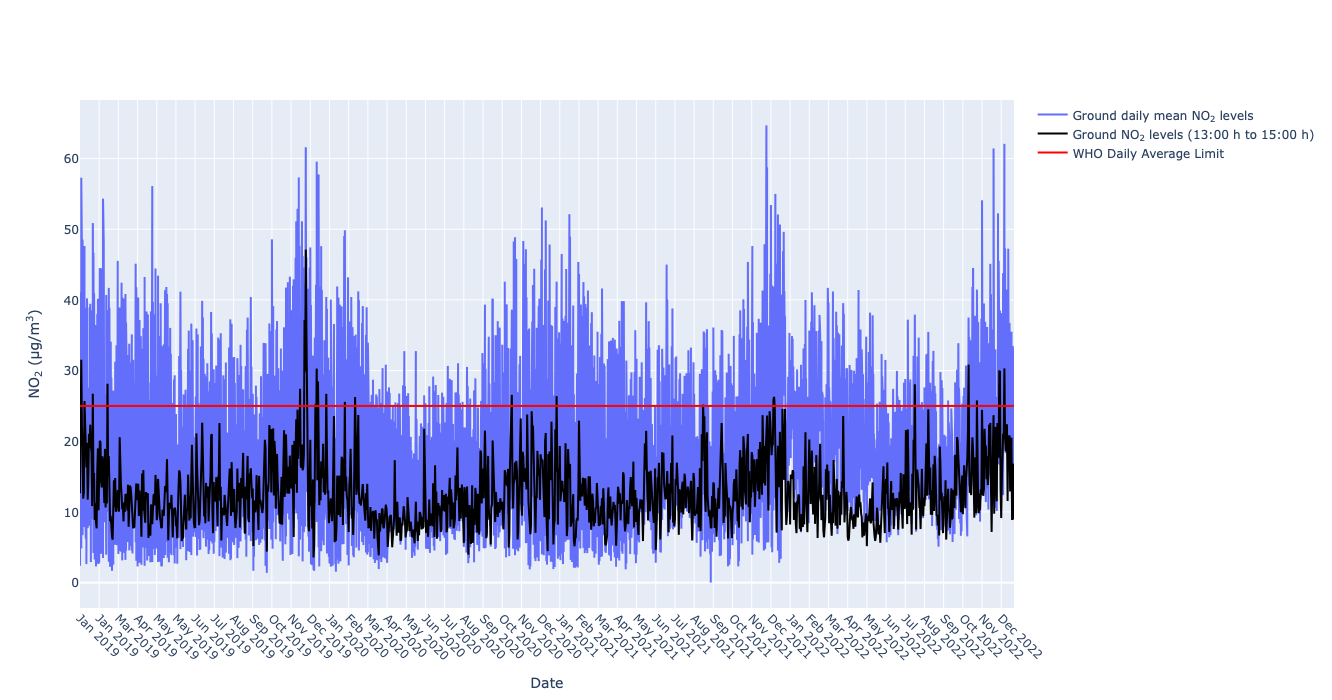

In [38]:
# Daily average NO2

cdmx_no2_date = cdmx_no2.reset_index(drop=False)
cdmx_no2_date = cdmx_no2_date[cdmx_no2_date["date"] < "2023-01-01"]
cdmx_no2_date["date"] = cdmx_no2_date["date"].dt.date
cdmx_no2_date.drop(columns=["lat", "lng", "geometry"], inplace=True)
cdmx_no2_date = cdmx_no2_date.groupby(["date", "station"]).mean()
cdmx_no2_date.reset_index(inplace=True, drop=False)

# Convert the 'date' column to datetime (if not already in datetime format) and create new dataframe only for the plotting
df_plot = cdmx_no2.reset_index(drop=False)
df_plot = df_plot[["date", "ground_no2"]]
start_time = "13:00:00"
end_time = "15:00:00"
df_plot = df_plot[
    (df_plot["date"].dt.time >= pd.to_datetime(start_time).time())
    & (df_plot["date"].dt.time <= pd.to_datetime(end_time).time())
]
df_plot["date"] = pd.to_datetime(df_plot["date"], format="%Y-%m-%d")
df_plot = df_plot[df_plot["date"] < "2023-01-01"]
df_plot = df_plot[df_plot["date"] < "2023-01-01"]
df_plot["day"] = df_plot["date"].dt.date
df_plot = df_plot.groupby("day").mean()

# Group by month-year and calculate mean
# df_plot = df_plot.groupby("date").mean()
df_plot.drop(columns="date")
df_plot.rename(columns={"day": "date"}, inplace=True)
df_plot = df_plot.reset_index(drop=False)
df_plot["date"] = pd.to_datetime(df_plot["date"], format="%Y-%m-%d")
df_plot["date_month"] = df_plot["date"].dt.strftime("%b %Y")
df_plot.set_index("date", inplace=True)
df_plot.reset_index(drop=False, inplace=True)
df_plot["date"] = df_plot["date"].dt.strftime("%Y-%m-%d")

# Create the plot using plotly.graph_objects
fig = go.Figure()

# Create the plot using plotly.express

fig.add_trace(
    go.Scatter(
        x=cdmx_no2_date["date"],
        y=cdmx_no2_date["ground_no2"],
        mode="lines",
        name="Ground daily mean NO<sub>2</sub> levels",
    )
)

fig.add_trace(
    go.Scatter(
        x=df_plot["date"],
        y=df_plot["ground_no2"],
        mode="lines",
        name="Ground NO<sub>2</sub> levels (13:00 h to 15:00 h)",
        line=dict(color="black"),
    )
)


# Update layout
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="NO<sub>2</sub> (µg/m<sup>3</sup>)",
    xaxis=dict(
        tickmode="array",
        tickvals=df_plot["date"].tolist()[::30],  # Use 'date' column for tick values
        ticktext=df_plot["date_month"].tolist()[
            ::30
        ],  # Use 'date_month' column for tick labels
        type="category",  # Use 'category' type for the x-axis
        tickangle=45,
    ),
    width=1200,  # Adjust width as needed
    height=700,
)
fig.add_trace(
    go.Scatter(
        x=[df_plot["date"].min(), df_plot["date"].max()],
        y=[25, 25],
        mode="lines",
        line=dict(color="Red", width=2),
        name="WHO Daily Average Limit",
        showlegend=True,
    )
)

# Show the plot
fig.show()

In [66]:
print(
    str(len(df_plot[df_plot["ground_no2"] > 25]))
    + " days out of "
    + str(len(df_plot))
    + " surpassed the WHO daily limit"
)

306 days out of 1461 surpassed the WHO daily limit


In [79]:
print(
    str(
        len(
            df_plot[
                (df_plot["ground_no2"] > 25)
                & (df_plot["date"] > "2021-12-31")
                & (df_plot["date"] < "2023-01-01")
            ]
        )
    )
    + " days out of "
    + str(
        len(
            df_plot[(df_plot["date"] > "2021-12-31") & (df_plot["date"] < "2023-01-01")]
        )
    )
    + " surpassed the WHO daily limit"
)

79 days out of 365 surpassed the WHO daily limit


In [48]:
df_complete_cdmx = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/cdmx-df_complete-2024_06_05.csv",
    index_col=0,
)

df_complete_mcm = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/milano-df_complete-2024_06_18.csv",
    index_col=0,
)

In [61]:
df_complete_gp_cdmx = df_complete_cdmx.drop(columns=["geometry", "id"])
df_complete_gp_cdmx = df_complete_gp_cdmx.groupby(["date", "station"]).mean()
df_complete_gp_cdmx.reset_index(drop=False, inplace=True)
df_complete_gp_cdmx = df_complete_gp_cdmx.drop(columns=["date", "station"])

In [63]:
df_complete_gp_cdmx.corr().iloc[:, 0:1]

ground_no2
ground_no2                            1.000000
satellite_no2                         0.551671
curr_temp_celsius                    -0.493883
curr_surface_net_solar_radiation     -0.435630
curr_surface_net_thermal_radiation   -0.007861
curr_surface_pressure                 0.020379
curr_total_precipitation             -0.075653
curr_wind_dir                         0.098902
curr_wind_speed                      -0.047331
curr_boundary_layer_height           -0.453021
prev_temp_celsius                    -0.431961
prev_surface_net_solar_radiation     -0.286451
prev_surface_net_thermal_radiation   -0.114430
prev_surface_pressure                 0.022932
prev_total_precipitation             -0.170395
prev_wind_dir                        -0.032568
prev_wind_speed                      -0.199422
prev_boundary_layer_height           -0.211432
elevation                            -0.120735